## Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Изучение данных из файлов

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [ ]:
# ML
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor, plot_importance
from catboost import CatBoostRegressor

In [ ]:
df_electrode = pd.read_csv('/datasets/final_steel/data_arc.csv')
df_bulk_volume = pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
df_wire_volume = pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

В ходе работы с таблицами выяснилось, что все названия столбцов написаны не по общепринятым стандартам, я решил написать функцию и исправить это в самом начале.

In [ ]:
datasets = [df_electrode, df_bulk_volume, df_bulk_time, df_wire_volume, df_wire_time, df_gas, df_temp]

In [ ]:
def snake_case(df):
    df.columns = (df.columns.str.lower()).str.replace(' ', '_')

In [ ]:
for dataset in datasets:
    snake_case(dataset)

In [ ]:
df_bulk_time.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [ ]:
def information(data):
    print('Первые 15 строк таблицы:')
    display(data.head(15))
    print()
    print('Информация о столбцах таблицы методом .describe():')
    display(data.describe())
    print()
    print('Информация о столбцах таблицы методом .info():')
    display(data.info())
    print()
    print('Процент пропусков в каждом столбце в порядке убывания')
    display(data.isna().mean().sort_values(ascending = False))
    print()
    print('Кол-во дубликатов в таблице:')
    display(data.duplicated().sum())

## Информация по данным в каждой таблице

### Данные об электродах

In [ ]:
information(df_electrode)

Первые 15 строк таблицы:


,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494



Информация о столбцах таблицы методом .describe():


,key,активная_мощность,реактивная_мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало_нагрева_дугой  14876 non-null  object 
 2   конец_нагрева_дугой   14876 non-null  object 
 3   активная_мощность     14876 non-null  float64
 4   реактивная_мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None


Процент пропусков в каждом столбце в порядке убывания


key                     0.0
начало_нагрева_дугой    0.0
конец_нагрева_дугой     0.0
активная_мощность       0.0
реактивная_мощность     0.0
dtype: float64


Кол-во дубликатов в таблице:


0

In [ ]:
df_electrode.rename(columns={'активная_мощность': 'active_power', 'реактивная_мощность': 'reactive_power',
                         'начало_нагрева_дугой': 'start_of_heating', 'конец_нагрева_дугой': 'end_of_heating'}, inplace=True)


In [ ]:
df_electrode['start_of_heating']=pd.to_datetime(df_electrode['start_of_heating'])
df_electrode['end_of_heating']=pd.to_datetime(df_electrode['end_of_heating'])

Исходя из описания данных методом .describe(), можно заметить, что в значении реактивной мощности есть отрицательное значение, возможно не одно, проверим это:

In [ ]:
df_electrode[df_electrode['reactive_power']<=0]

,key,start_of_heating,end_of_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Удалим записи с отрицательными значениями мощности:

In [ ]:
df_electrode[df_electrode['key']==2116]

,key,start_of_heating,end_of_heating,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [ ]:
df_electrode = df_electrode[df_electrode['key'] != 2116]

Проверка

In [ ]:
df_electrode[df_electrode['reactive_power']<=0]

,key,start_of_heating,end_of_heating,active_power,reactive_power


### Данные о подаче сыпучих материалов (объём)

In [ ]:
information(df_bulk_volume)

Первые 15 строк таблицы:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0



Информация о столбцах таблицы методом .describe():


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None


Процент пропусков в каждом столбце в порядке убывания


bulk_8     0.999680
bulk_13    0.994247
bulk_9     0.993928
bulk_2     0.992969
bulk_7     0.992010
bulk_5     0.975391
bulk_10    0.943752
bulk_11    0.943432
bulk_1     0.919463
bulk_6     0.815916
bulk_4     0.675935
bulk_3     0.585171
bulk_15    0.281560
bulk_12    0.217002
bulk_14    0.103228
key        0.000000
dtype: float64


Кол-во дубликатов в таблице:


0

Заменим пропуски нулями, отсутствие значений скорее всего значит то, то сыпучие материалы просто не были добавлены.

In [ ]:
df_bulk_volume = df_bulk_volume.fillna(0)

In [ ]:
df_bulk_volume.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


### Данные о подаче сыпучих материалов (время)

In [ ]:
information(df_bulk_time)

Первые 15 строк таблицы:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52



Информация о столбцах таблицы методом .describe():


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None


Процент пропусков в каждом столбце в порядке убывания


bulk_8     0.999680
bulk_13    0.994247
bulk_9     0.993928
bulk_2     0.992969
bulk_7     0.992010
bulk_5     0.975391
bulk_10    0.943752
bulk_11    0.943432
bulk_1     0.919463
bulk_6     0.815916
bulk_4     0.675935
bulk_3     0.585171
bulk_15    0.281560
bulk_12    0.217002
bulk_14    0.103228
key        0.000000
dtype: float64


Кол-во дубликатов в таблице:


0

Приведем данные к корректному для времени типу:

In [ ]:
for column in df_bulk_time.columns[1:]:
    df_bulk_time[column] = pd.to_datetime(df_bulk_time[column])

In [ ]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


### Данные о продувке сплава газом

In [ ]:
information(df_gas)

Первые 15 строк таблицы:


,key,газ_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891



Информация о столбцах таблицы методом .describe():


,key,газ_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


Процент пропусков в каждом столбце в порядке убывания


key      0.0
газ_1    0.0
dtype: float64


Кол-во дубликатов в таблице:


0

Переименуем столбец:

In [ ]:
df_gas.rename(columns={'газ_1': 'gas_1'}, inplace=True)
df_gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### Результаты измерения температуры

In [ ]:
information(df_temp)

Первые 15 строк таблицы:


,key,время_замера,температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0



Информация о столбцах таблицы методом .describe():


,key,температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   время_замера  15907 non-null  object 
 2   температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None


Процент пропусков в каждом столбце в порядке убывания


температура     0.182373
key             0.000000
время_замера    0.000000
dtype: float64


Кол-во дубликатов в таблице:


0

Переименуем столбцы:

In [ ]:
df_temp.rename(columns={'время_замера': 'measurement_time', 'температура': 'temperature'}, inplace=True)
df_temp.head()

,key,measurement_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [ ]:
df_temp['measurement_time'] = pd.to_datetime(df_temp['measurement_time'])

In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               15907 non-null  int64         
 1   measurement_time  15907 non-null  datetime64[ns]
 2   temperature       13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Избавимся от данных с пропусками по замерам температуры, т.к. это целевой признак.

In [ ]:
df_temp = df_temp.dropna()

### Данные о проволочных материалах (объём)

In [ ]:
information(df_wire_volume)

Первые 15 строк таблицы:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Информация о столбцах таблицы методом .describe():


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


Процент пропусков в каждом столбце в порядке убывания


wire_5    0.999675
wire_7    0.996430
wire_4    0.995456
wire_8    0.993833
wire_9    0.990587
wire_3    0.979552
wire_6    0.976306
wire_2    0.649789
wire_1    0.008439
key       0.000000
dtype: float64


Кол-во дубликатов в таблице:


0

С пропусками поступаем аналогично таблице с сыпучими материалами:

In [ ]:
df_wire_volume = df_wire_volume.fillna(0)

In [ ]:
df_wire_volume.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Данные о проволочных материалах (время)

In [ ]:
information(df_wire_time)

Первые 15 строк таблицы:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Информация о столбцах таблицы методом .describe():


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None


Процент пропусков в каждом столбце в порядке убывания


wire_5    0.999675
wire_7    0.996430
wire_4    0.995456
wire_8    0.993833
wire_9    0.990587
wire_3    0.979552
wire_6    0.976306
wire_2    0.649789
wire_1    0.008439
key       0.000000
dtype: float64


Кол-во дубликатов в таблице:


0

Приводим данные к нужному типу:

In [ ]:
for column in df_wire_time.columns[1:]:
    df_wire_time[column] = pd.to_datetime(df_wire_time[column])

In [ ]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


## Исследование выбросов в данных

Некоторые выбросы были убраны еще на этапе ознакомленеиея с данными, теперь хочется детальнее изучить данные.

Для нахождения межквартильного размаха и построения диаграмм размаха, напишем функцию:

In [ ]:
def boxplot_and_IQR(data, column):
    #Вычислим границы выбросов:
    # Первая квантиль
    Q1 = data[column].quantile(0.25)
    # Третья квантиль
    Q3 = data[column].quantile(0.75)
    # Межквантильное расстояние
    IQR = Q3 - Q1
    
    min_range = Q1 - 1.5 * IQR
    max_range = Q3 + 1.5 * IQR
    
    if min_range < 0:
        min_range = 0
    
    plt.figure(figsize=(15,3))
    sns.boxplot(data[column])
    plt.show()
    
    print('Нижняя граница:', min_range)
    print('Верхняя граница:', max_range)

### Данные об электродах

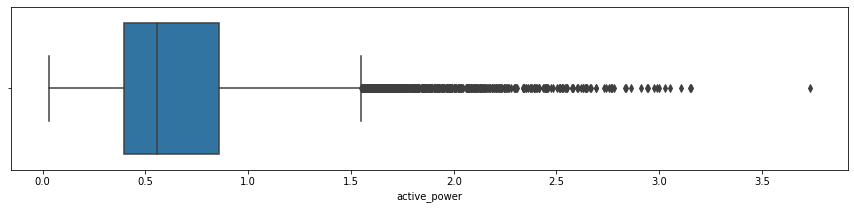

Нижняя граница: 0
Верхняя граница: 1.5498564183374999


In [ ]:
boxplot_and_IQR(df_electrode, 'active_power')

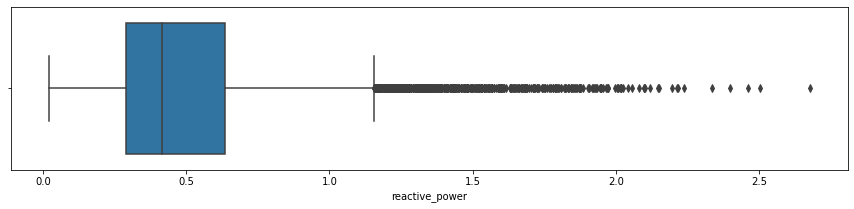

Нижняя граница: 0
Верхняя граница: 1.1571768374


In [ ]:
boxplot_and_IQR(df_electrode, 'reactive_power')

### Данные о продувке сплава газом

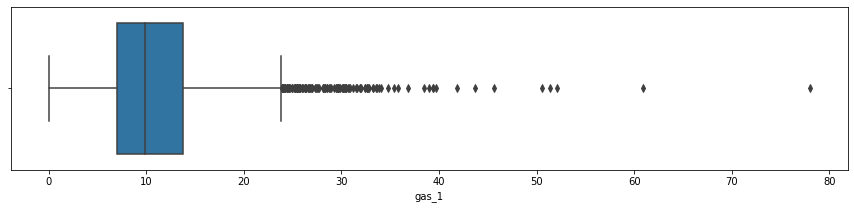

Нижняя граница: 0
Верхняя граница: 23.860155585675002


In [ ]:
boxplot_and_IQR(df_gas, 'gas_1')

### Результаты измерения температуры

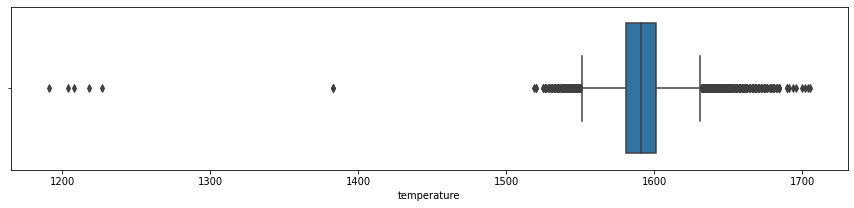

Нижняя граница: 1551.0
Верхняя граница: 1631.0


In [ ]:
boxplot_and_IQR(df_temp, 'temperature')

### Выводы по исследованию данных и исправление данных

Думаю данные по мощности и газу корректны, а вот партии с температурами меньшими 1400 градусов, стоит удалить

In [ ]:
df_temp[df_temp['temperature']<1400]

,key,measurement_time,temperature
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


In [ ]:
wrong_keys = list(df_temp[df_temp['temperature']<1400]['key'])
wrong_keys

[867, 1214, 1619, 1818, 1818, 2052, 2561]

In [ ]:
df_temp = df_temp.query('key not in @wrong_keys')

In [ ]:
df_temp[df_temp['temperature']<1400]

,key,measurement_time,temperature


## Добавление новых фичей

Определим начальную и конечную температуру в партии, заодно удалим все измерения температур, где был только один замер.

In [ ]:
df_temp

,key,measurement_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15878,3237,2019-08-31 22:44:04,1569.0
15883,3238,2019-08-31 23:30:31,1584.0
15886,3239,2019-09-01 01:31:47,1598.0
15894,3240,2019-09-01 02:39:01,1617.0


In [ ]:
df_first_temp = pd.merge(df_temp.groupby('key')['measurement_time'].agg('min'), df_temp, how='left', on='measurement_time')
df_last_temp = pd.merge(df_temp.groupby('key')['measurement_time'].agg('max'), df_temp, how='left', on='measurement_time')
df_count_temp = df_temp.drop(['measurement_time'], axis=1).groupby('key').agg('count')
df_temp_final = pd.merge(df_first_temp[['key','temperature']], df_last_temp[['key','temperature']], how='outer', on='key')
df_temp_final = pd.merge(df_temp_final, df_count_temp, how='outer', on='key')
df_temp_final.rename(columns={'temperature_x': 'first_temperature', 'temperature_y': 'last_temperature', 'temperature': 'count_of_measurements'}, inplace=True)
df_temp_final

,key,first_temperature,last_temperature,count_of_measurements
0,1,1571.0,1613.0,5
1,2,1581.0,1602.0,6
2,3,1596.0,1599.0,5
3,4,1601.0,1625.0,3
4,5,1576.0,1602.0,2
...,...,...,...,...
3205,3237,1569.0,1569.0,1
3206,3238,1584.0,1584.0,1
3207,3239,1598.0,1598.0,1
3208,3240,1617.0,1617.0,1


удалим партии с 1 измерением и удалим столбец с колицеством измерений, он нам больше не пригодится

In [ ]:
df_temp_final = df_temp_final[df_temp_final['count_of_measurements']>1]
df_temp_final = df_temp_final.drop(['count_of_measurements'], axis=1)
df_temp_final

,key,first_temperature,last_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2467,2495,1570.0,1591.0
2468,2496,1554.0,1591.0
2469,2497,1571.0,1589.0
2470,2498,1591.0,1594.0


Добавим признак время нагрева, в таблице df_electrode:

In [ ]:
df_electrode['time_of_heating'] = (df_electrode['end_of_heating'] - df_electrode['start_of_heating'])

In [ ]:
df_electrode.head()

,key,start_of_heating,end_of_heating,active_power,reactive_power,time_of_heating
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28


In [ ]:
df_electrode['full_power'] = np.sqrt(df_electrode['active_power']**2 + df_electrode['reactive_power']**2)

Добавим количество нагревов электродами, в таблице df_electrode:

In [ ]:
df_electrode_1 = df_electrode.groupby('key')['time_of_heating'].count().reset_index()
df_electrode_1.columns=['key','count_heating']
df_electrode_1.head()

,key,count_heating
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4


Добавим суммарное время нагревов электродами, в таблице df_electrode:

In [ ]:
df_electrode_1['full_time_heating'] = df_electrode.groupby('key')['time_of_heating'].sum().reset_index(drop=True)/np.timedelta64(1, "m")
df_electrode_1['active_power'] = df_electrode.groupby('key')['active_power'].sum().reset_index(drop=True)
df_electrode_1['reactive_power'] = df_electrode.groupby('key')['reactive_power'].sum().reset_index(drop=True)
df_electrode_1['full_power'] = df_electrode.groupby('key')['full_power'].sum().reset_index(drop=True)
df_electrode_1.head()

,key,count_heating,full_time_heating,active_power,reactive_power,full_power
0,1,5,18.300000,4.878147,3.183241,5.826395
1,2,4,13.516667,3.052598,1.998112,3.649216
2,3,5,10.916667,2.525882,1.599076,2.989534
3,4,4,12.350000,3.209250,2.060298,3.814962
4,5,4,14.483333,3.347173,2.252643,4.035758


## Формирование итоговой таблицы для моделей

In [ ]:
df_final = df_temp_final.merge(df_electrode_1, how='inner', on=['key'])
df_final.head()

,key,first_temperature,last_temperature,count_heating,full_time_heating,active_power,reactive_power,full_power
0,1,1571.0,1613.0,5,18.300000,4.878147,3.183241,5.826395
1,2,1581.0,1602.0,4,13.516667,3.052598,1.998112,3.649216
2,3,1596.0,1599.0,5,10.916667,2.525882,1.599076,2.989534
3,4,1601.0,1625.0,4,12.350000,3.209250,2.060298,3.814962
4,5,1576.0,1602.0,4,14.483333,3.347173,2.252643,4.035758


In [ ]:
df_final = df_final.merge(df_gas, on=['key'], how='inner')
df_final.head()

,key,first_temperature,last_temperature,count_heating,full_time_heating,active_power,reactive_power,full_power,gas_1
0,1,1571.0,1613.0,5,18.300000,4.878147,3.183241,5.826395,29.749986
1,2,1581.0,1602.0,4,13.516667,3.052598,1.998112,3.649216,12.555561
2,3,1596.0,1599.0,5,10.916667,2.525882,1.599076,2.989534,28.554793
3,4,1601.0,1625.0,4,12.350000,3.209250,2.060298,3.814962,18.841219
4,5,1576.0,1602.0,4,14.483333,3.347173,2.252643,4.035758,5.413692


In [ ]:
df_final = df_final.merge(df_bulk_volume, how='inner', on=['key'])
df_final.head()

,key,first_temperature,last_temperature,count_heating,full_time_heating,active_power,reactive_power,full_power,gas_1,bulk_1,...,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,1571.0,1613.0,5,18.300000,4.878147,3.183241,5.826395,29.749986,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,1581.0,1602.0,4,13.516667,3.052598,1.998112,3.649216,12.555561,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,1596.0,1599.0,5,10.916667,2.525882,1.599076,2.989534,28.554793,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,1601.0,1625.0,4,12.350000,3.209250,2.060298,3.814962,18.841219,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,1576.0,1602.0,4,14.483333,3.347173,2.252643,4.035758,5.413692,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [ ]:
df_final = df_final.merge(df_wire_volume, how='inner', on=['key'])
df_final.head()

,key,first_temperature,last_temperature,count_heating,full_time_heating,active_power,reactive_power,full_power,gas_1,bulk_1,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,5,18.300000,4.878147,3.183241,5.826395,29.749986,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,4,13.516667,3.052598,1.998112,3.649216,12.555561,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,5,10.916667,2.525882,1.599076,2.989534,28.554793,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,4,12.350000,3.209250,2.060298,3.814962,18.841219,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,4,14.483333,3.347173,2.252643,4.035758,5.413692,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2324 non-null   int64  
 1   first_temperature  2324 non-null   float64
 2   last_temperature   2324 non-null   float64
 3   count_heating      2324 non-null   int64  
 4   full_time_heating  2324 non-null   float64
 5   active_power       2324 non-null   float64
 6   reactive_power     2324 non-null   float64
 7   full_power         2324 non-null   float64
 8   gas_1              2324 non-null   float64
 9   bulk_1             2324 non-null   float64
 10  bulk_2             2324 non-null   float64
 11  bulk_3             2324 non-null   float64
 12  bulk_4             2324 non-null   float64
 13  bulk_5             2324 non-null   float64
 14  bulk_6             2324 non-null   float64
 15  bulk_7             2324 non-null   float64
 16  bulk_8             2324 

## План дальнейшей работы:  
- Провести исследовательский анализ данных:
    - Посмотреть на распределение исходных данных
    - Проанализировать порядок событий в производственном процессе
    - Исключить партии, которые не имеют последнего замера темпиратуры, либо первый замер соответствует последнему, либо замеры отсутствуют 
    - Оставить только события, которые находятся в промежутке между первым и последним замерами
- Подобрать признаки, на которых будет обучаться модель:
    - Сгенерировать ряд признаков
    - Проверить признаки на мультиколлинеарность, исключить лишние
    - Провести масштабирование признаков
- Построить модель, которая предскажет температуру стали:
    - Сформировать обучающую, валидационную и тестовую выборки
    - Выбрать несколько моделей и проверить их эффективность на валидационной выборке с помощью показателя эффективности MAE
    - Эффективность лучшей модели проверить на тестовой выборке

## Модель


In [ ]:
SEED = 244466666

### Работа с фичами для моделей

Посмотрим на матрицу корреляции признаков:

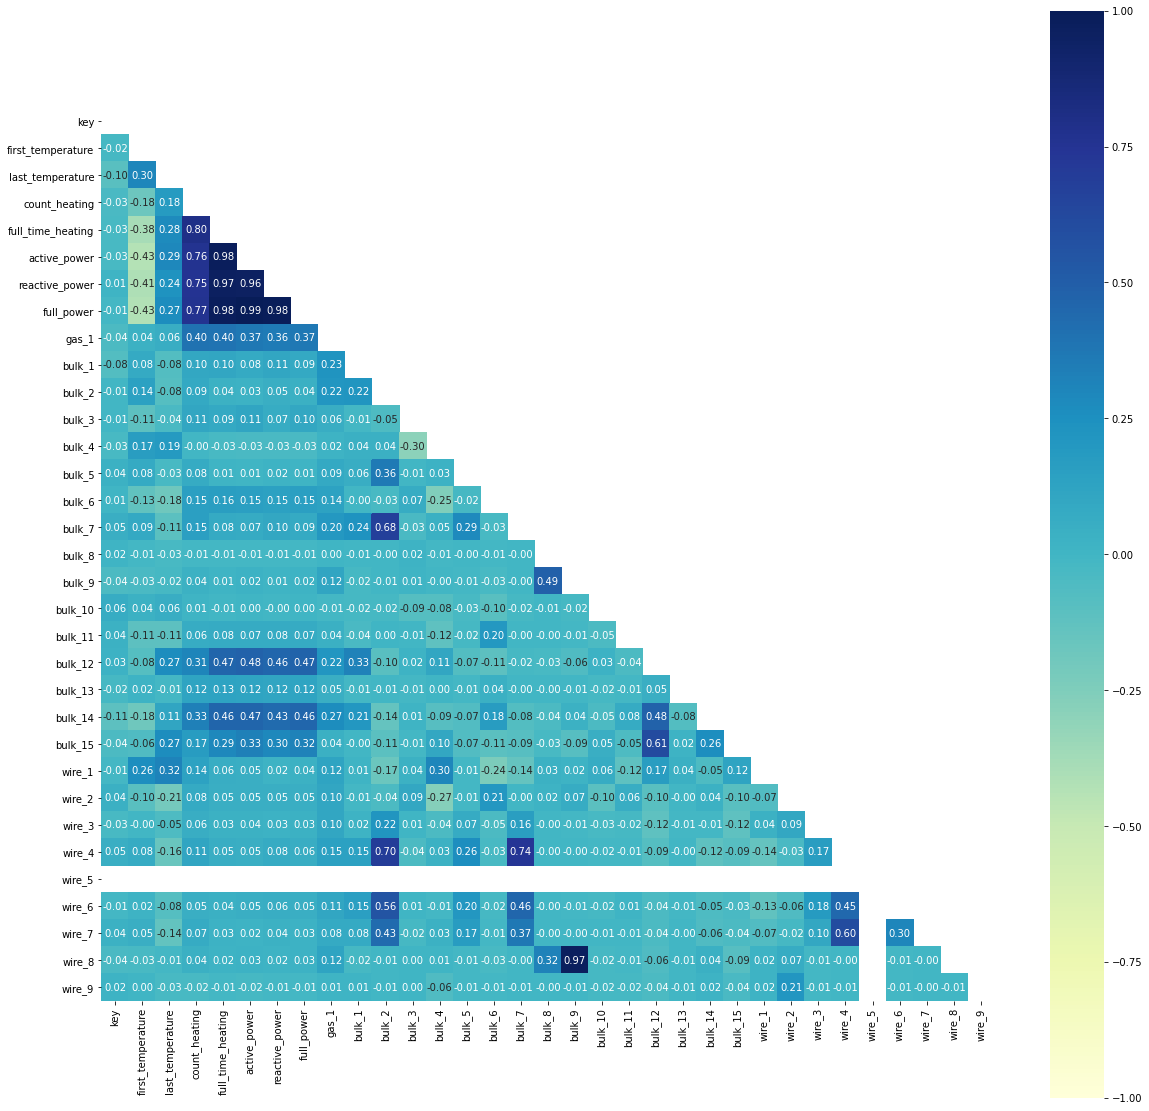

In [ ]:
plt.figure(figsize=(20,20))
matrix = np.triu(df_final.corr())
sns.heatmap(df_final.corr(), annot=True, fmt='.2f', cmap="YlGnBu", mask=matrix, square=True, vmin=-1, vmax=1, center= 0)
plt.show()

bulk_2, bulk_7 и bulk_9 или wire_8 стоит удалить, сильно коррелируют с другими признаками, key_5 нужно удалить по причине ненужности. Посмотрим на распределение важности признаков и после этого оставим только нужные фичи.

Разобьем данные на обучающую и тестовую выборку:

In [ ]:
features = df_final.drop('last_temperature', axis=1)
target = df_final['last_temperature']


features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=SEED)

print('Размер обучающей выборки', features_train.shape)
print('Размер тестовой выборки', features_test.shape)
print('Размер обучающего таргета', target_train.shape)
print('Размер тестового таргета', target_test.shape)

Размер обучающей выборки (1743, 32)
Размер тестовой выборки (581, 32)
Размер обучающего таргета (1743,)
Размер тестового таргета (581,)


Посмотрим на распределение важности факторов:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

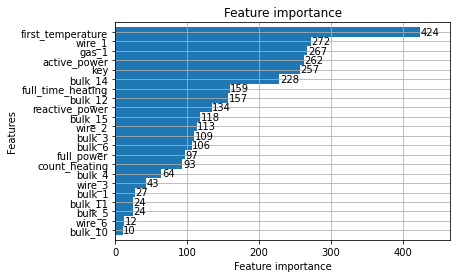

In [ ]:
model = LGBMRegressor()
model.fit(features_train, target_train)

plot_importance(model, height=1)

Оставим только самые значимые признаки в итовом датасете:

In [ ]:
df_final_1 = df_final.loc[:,['first_temperature', 'wire_1', 'full_power', 'gas_1', 'full_time_heating', 'bulk_14', 'bulk_12', 'wire_2', 'bulk_3', 'bulk_15', 'bulk_6', 'bulk_4', 'bulk_1', 'wire_6', 'bulk_11', 'bulk_10' ,'last_temperature']]

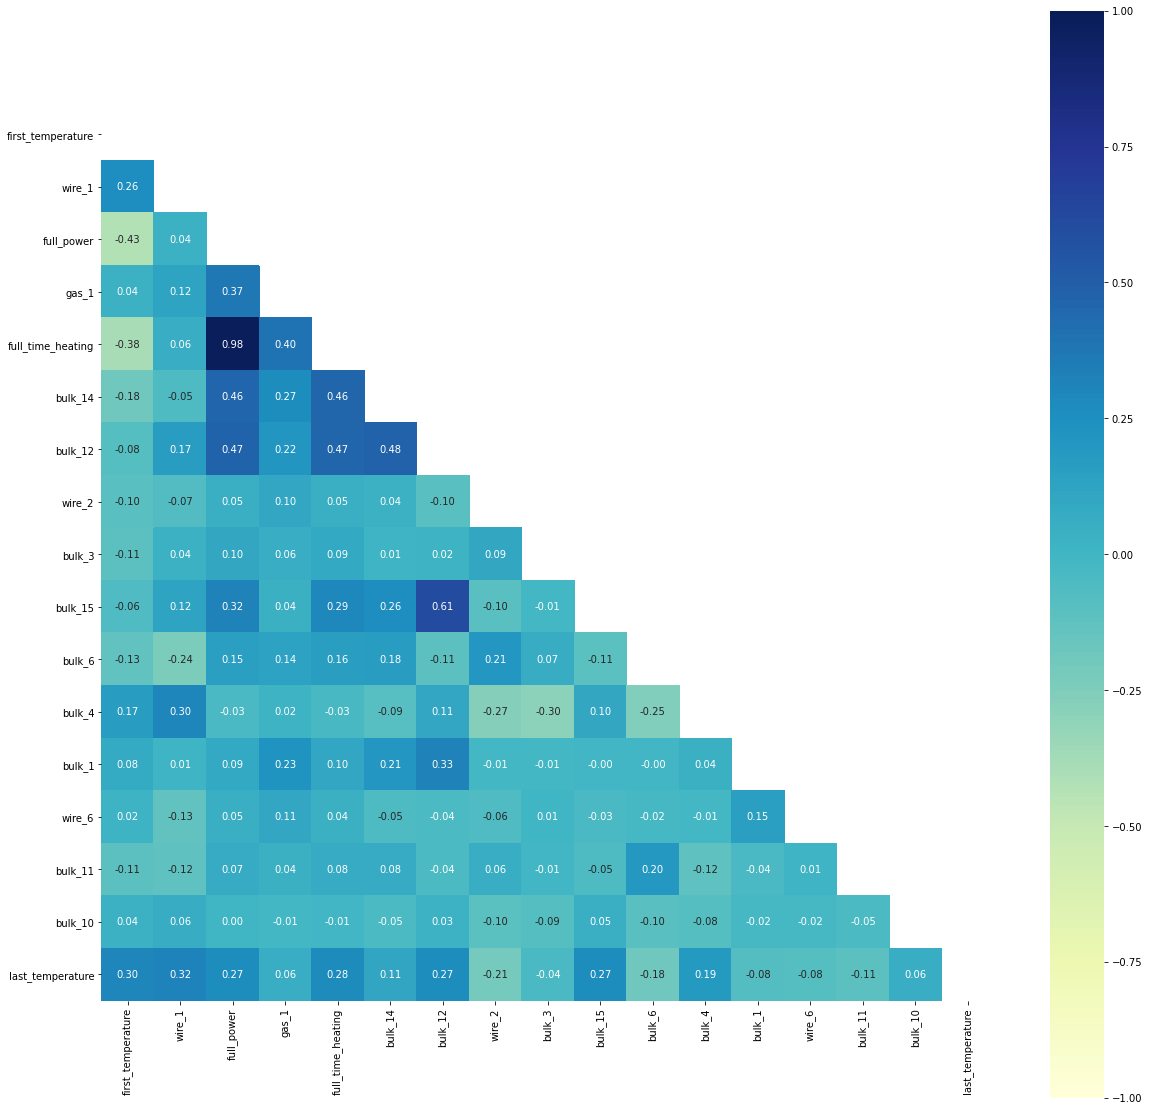

In [ ]:
plt.figure(figsize=(20,20))
matrix = np.triu(df_final_1.corr())
sns.heatmap(df_final_1.corr(), annot=True, fmt='.2f', cmap="YlGnBu", mask=matrix, square=True, vmin=-1, vmax=1, center= 0)
plt.show()

Параметры full_time_heating и full_power сильно коррелируют между собой, но я решил их оставить данных для обучения, т.к. по моему мнению это очень важные признаки, и удаление одного из них приведет к ушудщению качества предсказаний.

Разобьем итоговый датафрейм на обучающую и тестовую выборку:

In [ ]:
target = df_final_1['last_temperature']
features = df_final_1.drop('last_temperature', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=SEED)

Отмасштабируем признаки:

In [ ]:
scaler = StandardScaler().fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [ ]:
results = {
    'Constant_model': [],
    'Linear_regression_model': [],
    'Random_forest_model': [],
    'CatBoost_model': [],
    'LGBM_model': [],   
}

### Константная модель

In [ ]:
constant_model_predict = np.array([int(target_test.mean())] * int(target_test.count()))

print(mean_absolute_error(target_test, constant_model_predict))
results['Constant_model'].append(round(mean_absolute_error(target_test, constant_model_predict), 2))

7.208261617900172


### Линейная регрессия

In [ ]:
%%time
scores = cross_val_score(LinearRegression(), features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print(-np.mean(scores))

6.408896175313157
CPU times: user 26.6 ms, sys: 17.7 ms, total: 44.3 ms
Wall time: 13.4 ms


In [ ]:
%%time
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)
linear_model_prediction = linear_model.predict(features_test)
linear_model_mae = mean_absolute_error(target_test, linear_model_prediction)

print('MAE на тестовой выборке:', linear_model_mae)
results['Linear_regression_model'].append(round(linear_model_mae, 2))

MAE на тестовой выборке: 6.169352153465171
CPU times: user 10.2 ms, sys: 1.44 ms, total: 11.7 ms
Wall time: 3.73 ms


### Случайный лес

In [ ]:
%%time
scores = cross_val_score(RandomForestRegressor(random_state=SEED), features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print(-np.mean(scores))

6.365408589401572
CPU times: user 4.24 s, sys: 36.7 ms, total: 4.28 s
Wall time: 4.29 s


In [ ]:
# %%time
# grid = {'n_estimators': range(1, 402, 20), 'max_depth': range(1, 81), 'min_samples_leaf': range(1, 11)}

# model = RandomForestRegressor(random_state=SEED)
# random_search = RandomizedSearchCV(model,
#                                    grid,
#                                    cv=5,
#                                    random_state=SEED,
#                                    scoring='neg_mean_absolute_error'
#                                   )
# random_search.fit(features_train, target_train)

# print(random_search.best_params_)

{'n_estimators': 141, 'min_samples_leaf': 2, 'max_depth': 13}  
CPU times: user 1min 19s, sys: 420 ms, total: 1min 19s  
Wall time: 1min 23s

In [ ]:
%%time
random_forest_model = RandomForestRegressor(random_state=SEED, n_estimators=141, max_depth=13, min_samples_leaf=2)
random_forest_model.fit(features_train, target_train)

random_forest_prediction = random_forest_model.predict(features_test)
random_forest_mae = mean_absolute_error(target_test, random_forest_prediction)

print("MAE на тестовой выборке: ", random_forest_mae)
results['Random_forest_model'].append(round(random_forest_mae, 2))

MAE на тестовой выборке:  5.81093838822753
CPU times: user 1.15 s, sys: 446 µs, total: 1.15 s
Wall time: 1.15 s


### CatBoostRegressor

In [ ]:
%%time
scores = cross_val_score(CatBoostRegressor(random_state=SEED, silent=True), features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print(-np.mean(scores))

6.26925319524809
CPU times: user 15.2 s, sys: 537 ms, total: 15.8 s
Wall time: 24.2 s


In [ ]:
# %%time

# grid = {'iterations': range(1, 502, 50), 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8], 'depth': range(1, 32, 5)}

# model = CatBoostRegressor(random_state=SEED, loss_function='MAE', silent=True)
# random_search = model.randomized_search(grid,
#                                         X=features_train,
#                                         y=target_train,
#                                         partition_random_seed=SEED,
#                                         cv=5,
#                                         verbose=False)

# print(random_search['params'])

{'depth': 1, 'iterations': 251, 'learning_rate': 0.2}  
CPU times: user 28min 36s, sys: 28min 36s, total: 57min 12s  
Wall time: 57min 29s

In [ ]:
%%time
cat_model = CatBoostRegressor(random_state=SEED, loss_function="MAE", depth=1, iterations=251, learning_rate=0.2)
cat_model.fit(features_train, target_train, verbose=150)

cat_prediction = cat_model.predict(features_test)
cat_mae = mean_absolute_error(target_test, cat_prediction)

print('MAE на тестовой выборке:', cat_mae)
results['CatBoost_model'].append(round(cat_mae, 2))

0:	learn: 8.2745830	total: 532us	remaining: 133ms
150:	learn: 5.9719547	total: 76ms	remaining: 50.4ms
250:	learn: 5.8161282	total: 124ms	remaining: 0us
MAE на тестовой выборке: 5.655241801903827
CPU times: user 142 ms, sys: 35.7 ms, total: 178 ms
Wall time: 869 ms


### LGBMRegressor

In [ ]:
%%time
scores = cross_val_score(LGBMRegressor(random_state=SEED), features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print(-np.mean(scores))

6.604507575558328
CPU times: user 10min 36s, sys: 5.44 s, total: 10min 42s
Wall time: 10min 47s


In [ ]:
# %%time
# grid = {'max_depth': range(1, 31, 5), 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 'n_estimators': range(1, 502, 50)}

# model = LGBMRegressor(random_state=SEED)
# random_search = RandomizedSearchCV(model, grid, random_state=SEED, scoring='neg_mean_absolute_error', cv=5)

# random_search.fit(features_train, target_train)

# print(random_search.best_params_)

{'n_estimators': 51, 'max_depth': 21, 'learning_rate': 0.1}  
CPU times: user 2h 12min 28s, sys: 44.2 s, total: 2h 13min 12s  
Wall time: 2h 13min 47s

In [ ]:
%%time
lgbm_model = LGBMRegressor(random_state=SEED, num_iterations=51, max_depth=21, learning_rate=0.1)
lgbm_model.fit(features_train, target_train, verbose=150)

lgbm_prediction = lgbm_model.predict(features_test)
lgbm_mae = mean_absolute_error(target_test, lgbm_prediction)

print('MAE на тестовой выборке:', lgbm_mae)
results['LGBM_model'].append(round(lgbm_mae, 2))

MAE на тестовой выборке: 5.665583247179655
CPU times: user 39.5 s, sys: 317 ms, total: 39.8 s
Wall time: 40 s


## Вывод по работе с моделями

In [ ]:
results

{'Constant_model': [7.21],
 'Linear_regression_model': [6.17],
 'Random_forest_model': [5.81],
 'CatBoost_model': [5.66],
 'LGBM_model': [5.67]}

В ходе работы были пройдены следующие этапы:

- были добавлены новые фичи: первоначальная и конечные температуры, полная мощность, длительность нагрева и кол-во нагревов
- были удалены признаки с временем, признаки с маленьким кол-вом информации, признаки не вносящие сильную значимость в процесс обучения
- были обучены 4 модели машинного обучения и 1 константная модель, для сравнения

 Заказчику стоит рекомендовать использование модели CatBoost с указанными гиперпараметрами и итоговой метрикой MAE в 5.81, что удолетворяет требованиям бизнеса. В будущем возсможно дополнительное улучшение модели с помощью добавления новых фичей и более тонкого подбора гиперпараметров.

## Отчет по решению

В рамках данного проекта были выполнены следующие задачи:
- Были изучены данные в каждом датасете
- Была проведена предобработка данных, были выявлены пропуски и выбросы в данных 
- В ходе работы с существующими признаками были выделены новые, которые в значительной мере помогли улучшить качество итоговой модели
- На этапе работы с признаками были выделены признаки, наиболее важные для моделей
- В рамках работы непосредственно с моделями, было проведено сравнение линейной регрессии, случайного леса, CatBoost и LGBM моделей

По ходу выпонения проекта возникали незначительные трудности с выделением новых признаков, в остальном проблем не возникло. 

Ключевыми этапами работы на мой взгляд являются выделение новых признаков для модели и грамотный подбор гиперпараметров для моделей.

Заказчику стоит рекомендовать использование модели CatBoost с указанными гиперпараметрами и итоговой метрикой MAE в 5.81, что удолетворяет требованиям бизнеса. В будущем возможно дополнительное улучшение модели с помощью добавления новых фичей и более тонкого подбора гиперпараметров. Рекомендуется уменьшить разброс в измерениях замеров температуры или создать систему которая бы определяла аномальные замеры.